# AVL Trees

## Introduction to AVL Trees

- Let's introduce the concept of node **height**. The height of a node is just how far away they are from the nearest leaf, including itself
    - Any leaf has a height of 1 

- How do we compute the height of a node?
    - We can do this recursively! 
    - 1 if N is a leaf (doesn't matter if there are deeper leaves)
    - Else, N.Height is $1 + \max(\text{N.Left.Height}, \text{N.Right.Height})$

- Recall that previously, each node has 4 attributes: parent, key, left_child, and right_child. We now add Height as an attribute

In [2]:
from dataclasses import dataclass

@dataclass
class Node:
    key: int
    height: int
    parent: 'Node'
    left_child: 'Node'
    right_child: 'Node'

- So how does this relate to tree balance?
    - Simply, the height is an indirect measure of subtree size
    - If the size of subtrees are roughly the same, then the heights are roughly the same
    - This is the **AVL property** of a tree

- **AVL Property:** For all nodes $N$, AVL property is maintained when $$| \text{N.Left.Height} - \text{N.Right.Height} | \le 1 $$
    - This ensures balance

- If AVL property on all nodes then height is $O(\log(N))$

- Theorem: Let $N$ be some node of a binary tree satisfying the AVL property. Let $h = \text{N.Height}$. Then the subtree of $N$ has size at least the h-th Fibonacci number 

- Proof by induction on $h$
    - Base case
        - Let's assume a node $N$ with height $h=1$ (i.e. node is a leaf). 
        - Then the subtree of $N$ has size $1$ 
    - Inductive step
        - Let's assume a node $N$ with height $h > 1$ 
        - One subtree of $N$ must have height at least $h-1$. 
            - It cannot be more than h-1, otherwise the height of $N$ would be more than $h$
            - It cannot be less than h-1, otherwise the height of $N$ would be less than $h$
        - The other subtree must have height of at least $h-2$
            - It can be more than $h-2$, but not more than $h-1$
            - It cannot be less than $h-2$, since we assumed that the tree follows the AVL property, then height difference is at most 1
        - From base case:
            - If node $N$ has height 2, then the subtree heights must be at least $2-1 = 1$ and $2-2=0$. 
                - Subtrees of height 1 have minimum size 1
                - Subtrees of height 0 have minimum size 0
                - So subtrees of height 2 have at least size of 1
            - If node $N$ has height 3, then the subtree heights must be at least $3-1 = 2$ and $3-2=1$. 
                - Subtrees of height 2 have minimum size 1
                - Subtrees of height 1 have minimum size 1
                - So subtrees of height 3 have at least size of 2
            - You can see that you are just going to add the numbers sequentially, leading to Fibonacci series

- The lower bound of Fibonacci sequence is $2^{\frac{h}{2}}$. You can see proof here (https://proofwiki.org/wiki/Upper_and_Lower_Bound_of_Fibonacci_Number), though it is not crucial
    - Therefore, any node with height $h$ has subtree of size $n \ge 2^{\frac{h}{2}}$
    - Therefore $h \le 2 \cdot \log(n)$
    - Therefore $h$ is $O(\log(n))$

## Implementation of AVL Tree

- We have discussed why AVL property is good. But AVL property is destroyed by insertions and deletions!
    - How do we ensure that AVL property is preserved?

- Observations
    - 1. Deletion/Insertions don't affect the height of all nodes, only those that are in the path of the operation! This is because of the AVL property, where the tree is balanced. So rebalancing the tree should only take $O(\log(N))$

### Insertion

- We need an insertion algorithm that rebalances the tree to maintain AVL property. Turns out, it's not hard!
    - Given key $k$ and root $R$
    - Do an `Insert` (see notes under Binary search tree, already implemented)
    - Find the node with value $k$
    - Rebalance it

- How to rebalance a node $N$?
    - If AVL property already met, (i.e. height of left child and height of right child differs by at most 1), then do nothing
    - If height of left/right child exceeds right/left child by more than 1, then we need to move left/right child upwards!
    - So long as AVL property is maintained, tree should never be unbalanced by more than 2 (i.e. height difference cannot be more than 2)

- Pseudocode: `Rebalance(N)`
    - Store parent: `P = N.parent`
    - Check which direction to rebalance towards:
        - `if N.left_child.height > N.right_child.height + 1: RebalanceTowardsRight(N)`
        - `if N.right_child.height > N.left_child.height + 1: RebalanceTowardsLeft(N)`
    - Adjust height of $N$, which may have changed because of rebalancing
        - `AdjustHeight(N)`
    - Adjust height of $N$'s parent, which may have changed because of rebalancing
        - `if P != None: Rebalance(P)`
 

- However, there is a specific case where this rotation fails:
    - Suppose we have node $N$ with left child $A$ and right child $C$, that fail the AVL condition
    - If AVL fails because of the right child of $A$ (i.e. A's right child is heaviest)
    - Then when rotation to the right happens, $A$'s right child becomes $N$'s left child, which causes an unbalanced tree again
    

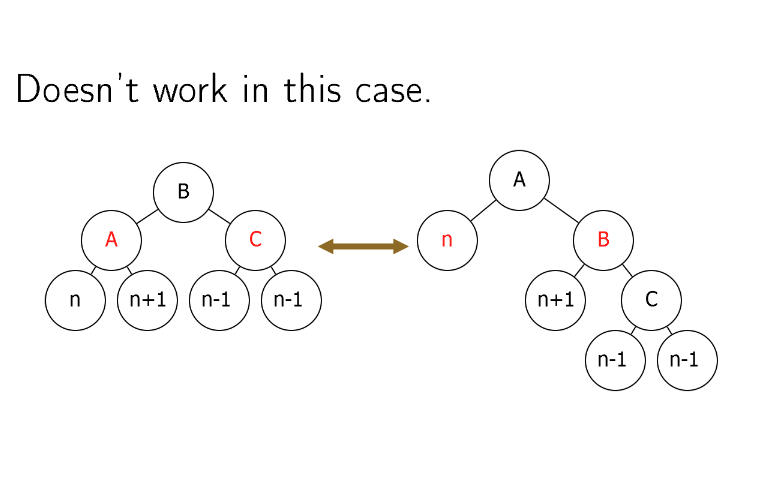

- To fix this, rotate the problematic grandchild leftwards, before rotating the whole tree rightwards

In [3]:
def AdjustHeight(N) -> Node:
    N.height = 1 + max(N.left_child.height, N.right_child.height)
    return N

def RotateRight(N):
    P = N.parent
    New_Root_Node = N.right_child.copy()
    Swap_Parent_Node = N.right_child.left_child.copy()
    
    ## Fix references to and from N's parent
    if P.key > N.key:
        ## N is left child
        P.left_child = New_Root_Node
    elif P.key < N.key:
        ## N is right child
        P.right_child = New_Root_Node
    
    ## For N, left branch does not change. Fix the reference to and from N's right branch
    Swap_Parent_Node.parent = N
    N.right_child = Swap_Parent_Node
    N.parent = New_Root_Node

    ## Fix references to and from new root node
    New_Root_Node.parent = P
    New_Root_Node.left_child = N


def RotateLeft(N):
    P = N.parent
    New_Root_Node = N.left_child.copy()
    Swap_Parent_Node = N.left_child.right_child.copy()
    
    ## Fix references to and from N's parent
    if P.key > N.key:
        ## N is left child
        P.left_child = New_Root_Node
    elif P.key < N.key:
        ## N is right child
        P.right_child = New_Root_Node
    
    ## For N, right branch does not change. Fix the reference to and from N's left branch
    Swap_Parent_Node.parent = N
    N.left_child = Swap_Parent_Node
    N.parent = New_Root_Node

    ## Fix references to and from new root node
    New_Root_Node.parent = P
    New_Root_Node.right_child = N
    
def RebalanceRight(N):
    M = N.left_child
    if M.right_child.height > M.left_child.height:
        RotateLeft(M)
        AdjustHeight(M)
    RotateRight(N)
    AdjustHeight(N)


### Deletion

- Same idea, deletion can decrease the height of a tree, which can cause the parent to become inbalanced
- Pseudocode
    - Delete(N)
    - M = Parent of node replacing N
    - Rebalance(M)

- Can be done in $O(\log(N))$ time!

### Merge

- Combine 2 binary search trees into 1
- Merging 2 sorted lists generally takes $O(N)$ time
- But if both lists are separated (i.e. all the keys in 1 list are smaller than the keys in the other), then it is a lot faster!

- So given roots $R_1$ and $R_2$ of 2 trees, where all keys in $R_1$ tree are smaller than those in $R_2$, output the root of a new tree with all elements of both trees

- Let's go through a trivial case. Suppose I am free to add an extra node to merge the 2 trees. Then the solution is trivial. I just need to add a new node above both $R_1, R_2$ with $R_1$ as the left child, and $R_2$ as the right

In [ ]:
def MergeWithRoot(r1: Node, r2: Node, t: Node):
    t.left_child = r1
    t.right_child = r2
    r1.parent = t
    r2.parent = t
    return t

- But as it turns out, we can do exactly this by taking the largest element from the $R_1$ subtree, and setting it as the node! 
    - It also works if we take the smallest element of $R_2$ and set it as the node, but we'll just do 1 case as the example

- This can be done in $O(\log(N))$ time, assuming AVL tree! Otherwise it's $O(h)$ where $h$ is the depth of the max value in left tree

In [ ]:
import math

def find(key: int, root: Node):
    curr_node = root
    if key == curr_node.key:
        return curr_node
    elif key < curr_node.key:
        return find(key, curr_node.left_child)
    else:
        return find(key, curr_node.right_child)

def delete(N: Node):
    ...

def Merge(r1: Node, r2: Node):
    T = find(int(math.inf), r1)
    delete(T)
    MergeWithRoot(r1, r2, T)
    return T

- But quite clearly, this merge doesn't maintain balance. The $r_1$ subtree could be a lot bigger/smaller than $r_2$, so merging them from their root nodes may not be ideal

- There is a way around this; instead of merging from the root, traverse down the larger tree until you find a node where the AVL condition is met, and do the merge there!

- This traversal will take at most $O(|\text{r1.height} - \text{r2.height}| + 1)$ 

In [ ]:
def AVLMergeWithRoot(r1, r2, T):
    if abs(r1.height - r2.height) <= 1:
        MergeWithRoot(r1, r2, T)
        T.height = max(r1.height, r2.height) + 1
        return T
    elif r1.height > r2.height:
        new_root = AVLMergeWithRoot(r1.right, r2, T)
        r1.right = new_root
        new_root.parent = r1
        RebalanceRight(r1)
        return new_root
    else:
        new_root = AVLMergeWithRoot(r1, r2.left, T)
        r2.left = new_root
        new_root.parent = r2
        RebalanceRight(r2)
        return new_root

### Split

- Break 1 binary tree into 2
- Given a root $R$ of a tree and a key $x$, return 2 trees, one with all elements $\le x$ and the other with all elements $\gt x$

- Approach:
    - Search for $x$
    - Once we get the position where $x$, anything we can split the tree into stuff that is larger and stuff that is smaller than x

In [ ]:
def split(r: Node, x: int):
    # If there is no root node, then there is nothing to split. Return none for the new roots
    if r is None:
        return (None, None)
    
    # If the value to find is lower than the root node, then everything to the right of r must be in the same subtree, because all values in the right tree must also be larger than x.
    # Therefore, we look at the left child of r and try to split it about the value x.
    # This will give us new roots r1 and r2. 
    # We know that r is the root of a tree that is larger than x, and r2 is also the root of a tree that is larger than x
    # Since r2 came from the left subtree of r, all values in r2 subtree must be less than r
    # So we can simply do a merge with root of r2 and r's right child, using r as the root
    if x <= r.key:
        r1, r2 = split(r.left_child, x)
        r3 = MergeWithRoot(r2, r.right_child, r)
        return (r1, r3)
    
    if x > r.key:
        r1, r2 = split(r.right_child, x)
        r3 = MergeWithRoot(r1, r.left_child, r)
        return (r3, r2)